In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/README.md.txt
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-173.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-334.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-309.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-487.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-178.png
/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-10.png
/kaggle/input/tuberculos

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

2025-05-30 20:25:31.671390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748636732.446839      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748636732.660608      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Constants
IMG_SIZE = 150
DATA_DIR = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'
LABELS = ['Normal', 'Tuberculosis']


In [4]:
import os

print("DATA_DIR:", DATA_DIR)
print("Subfolders:", os.listdir(DATA_DIR))


DATA_DIR: /kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database
Subfolders: ['Normal.metadata.xlsx', 'Tuberculosis', 'README.md.txt', 'Tuberculosis.metadata.xlsx', 'Normal']


In [5]:
def get_training_data(data_dir):
    data = []
    for label in LABELS:
        path = os.path.join(data_dir, label)
        class_num = LABELS.index(label)

        if not os.path.exists(path):
            print(f"Warning: {path} not found.")
            continue

        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    continue
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error: {e}")
    return np.array(data, dtype=object)

In [6]:
# Load and split data
data = get_training_data(DATA_DIR)
X = []
y = []

for feature, label in data:
    X.append(feature)
    y.append(label)

In [7]:
X = np.array(X) / 255.0
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)

In [10]:
# Model architecture (same as Pneumonia)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile it
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-30 20:27:24.231950: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 72, 72, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,995,649 (7.61 MB)

 Trainable params: 1,994,689 (7.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Learning rate reduction
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)


In [13]:
# Train model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=15,
    validation_data=(X_val, y_val),
    callbacks=[lr_reduce]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.7947 - loss: 1.3166 - val_accuracy: 0.5083 - val_loss: 1.0833 - learning_rate: 0.0010
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.8930 - loss: 0.2831 - val_accuracy: 0.5821 - val_loss: 0.8331 - learning_rate: 0.0010
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.9117 - loss: 0.2186 - val_accuracy: 0.4738 - val_loss: 1.0606 - learning_rate: 0.0010
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.9249 - loss: 0.2333 - val_accuracy: 0.7476 - val_loss: 0.5718 - learning_rate: 0.0010
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.9323 - loss: 0.1818 - val_accuracy: 0.1690 - val_loss: 6.7175 - learning_rate: 0.0010
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.9324 - loss: 0.1786 - val_accuracy: 0.8143 - val_loss: 0.4637 - learning_rate: 0.0010
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9406 - loss: 0.

In [14]:
# Evaluate
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {accuracy:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.9689 - loss: 0.1367
Validation accuracy: 0.9655


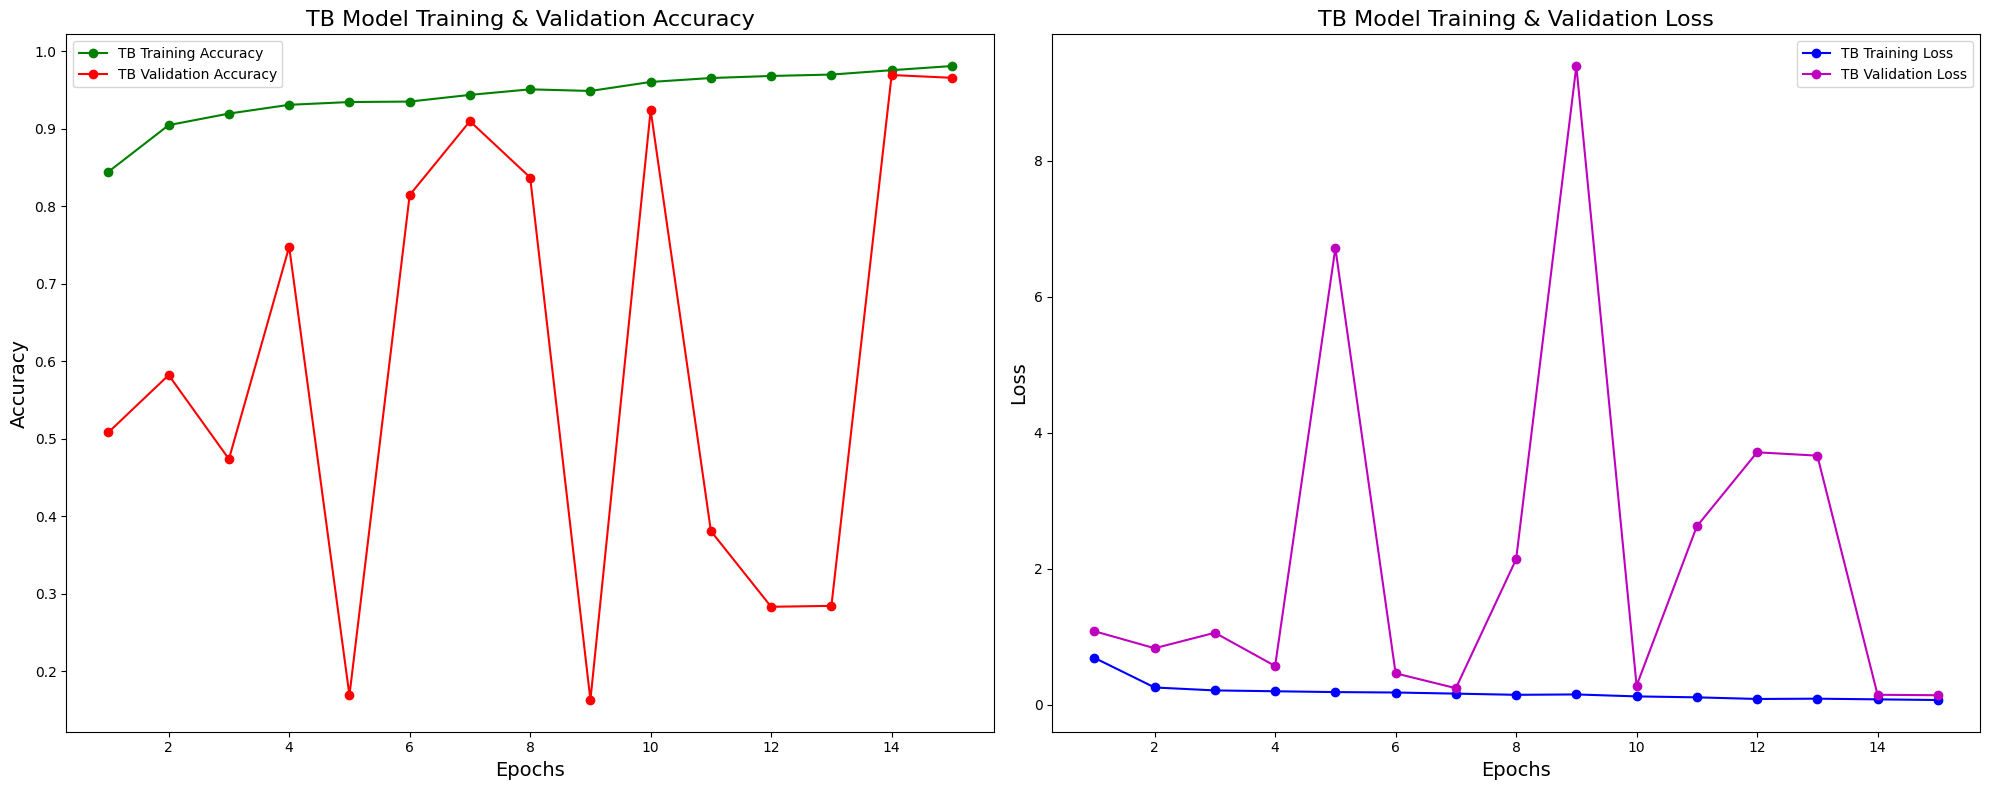

In [15]:
# Plotting Training & Validation Accuracy and Loss for TB model
epochs = range(1, 16)  # Since epochs=15 in training

# Extract metrics from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Accuracy plot
ax[0].plot(epochs, train_acc, 'g-o', label='TB Training Accuracy')
ax[0].plot(epochs, val_acc, 'r-o', label='TB Validation Accuracy')
ax[0].set_title('TB Model Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Accuracy', fontsize=14)
ax[0].legend()

# Loss plot
ax[1].plot(epochs, train_loss, 'b-o', label='TB Training Loss')
ax[1].plot(epochs, val_loss, 'm-o', label='TB Validation Loss')
ax[1].set_title('TB Model Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Loss', fontsize=14)
ax[1].legend()

plt.tight_layout()
plt.show()


27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step
                        precision    recall  f1-score   support

Tuberculosis (Class 0)       0.96      1.00      0.98       703
      Normal (Class 1)       0.99      0.80      0.88       137

              accuracy                           0.97       840
             macro avg       0.98      0.90      0.93       840
          weighted avg       0.97      0.97      0.96       840



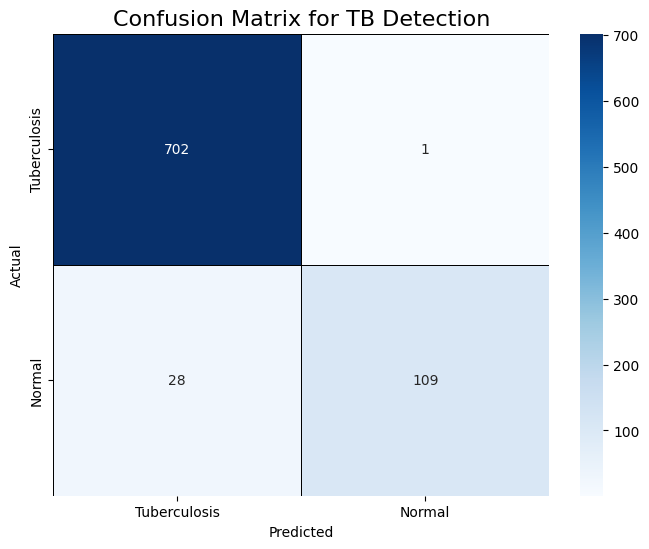

In [16]:
# TB Model Predictions on Validation Set
import pandas as pd
predictions = (model.predict(X_val) > 0.5).astype("int32").flatten()

# Classification Report for TB Detection
print(classification_report(y_val, predictions, target_names=['Tuberculosis (Class 0)', 'Normal (Class 1)']))

# Confusion Matrix Visualization
cm = confusion_matrix(y_val, predictions)
cm_df = pd.DataFrame(cm, index=['Tuberculosis', 'Normal'], columns=['Tuberculosis', 'Normal'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black')
plt.title("Confusion Matrix for TB Detection", fontsize=16)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


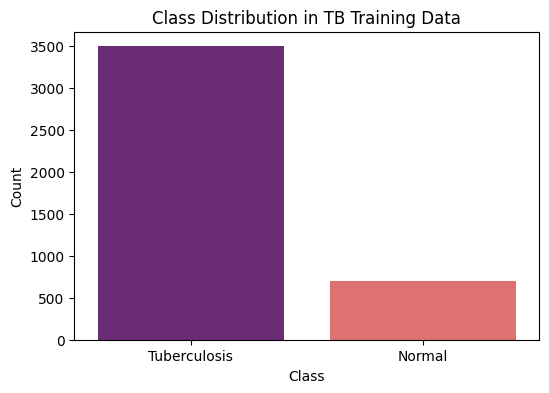

In [17]:
# Mapping labels for TB dataset
# Mapping labels for TB dataset
label_mapping = {0: "Tuberculosis", 1: "Normal"}

# Data Visualization - Class Distribution
plt.figure(figsize=(6, 4))
class_labels = [label_mapping[label] for _, label in data]
sns.countplot(x=class_labels, palette="magma")
plt.title("Class Distribution in TB Training Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

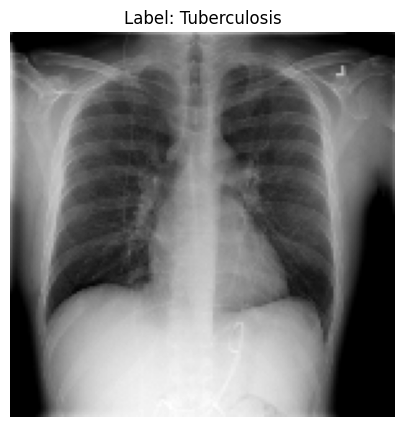

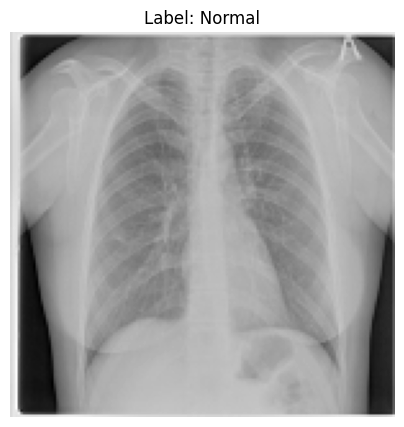

In [18]:
# Visualizing Sample Images
def plot_sample_image(image, label, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label_mapping[label]}")
    plt.axis('off')
    plt.show()

# Displaying the first and last images in the TB dataset
plot_sample_image(data[0][0], data[0][1])
plot_sample_image(data[-1][0], data[-1][1])


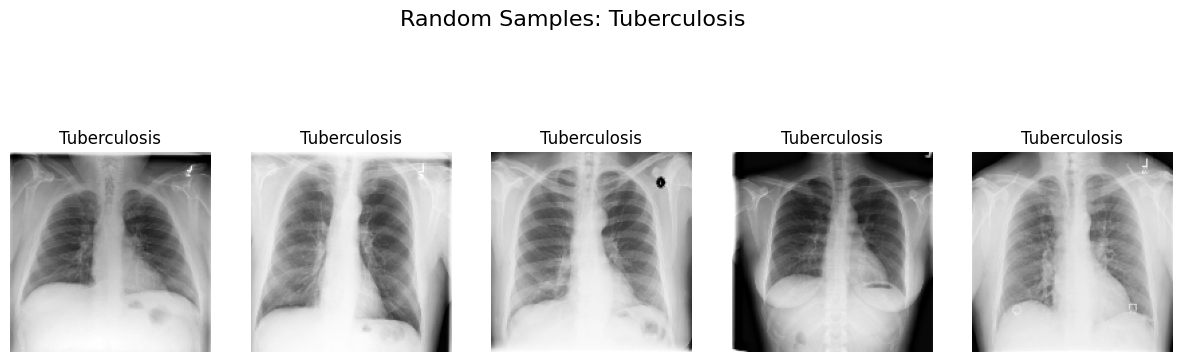

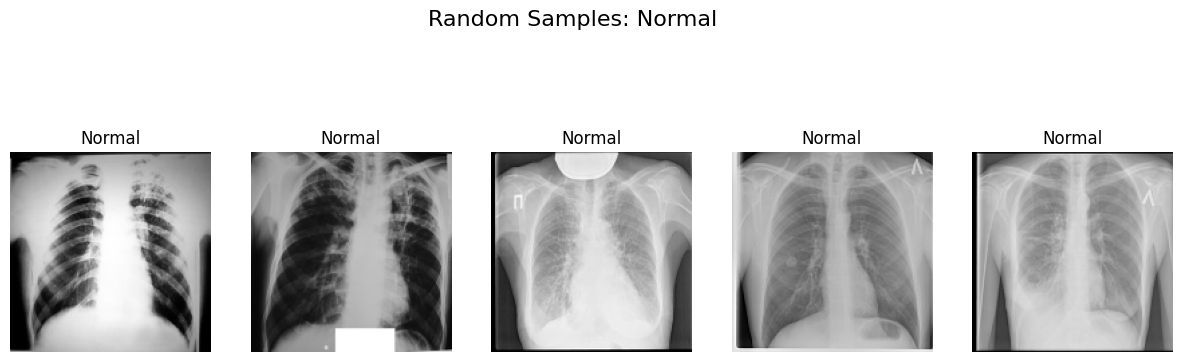

In [19]:
import random

# Separate images by class
tb_images = [img for img, label in data if label == 0]
normal_images = [img for img, label in data if label == 1]

# Function to plot a grid of images
def plot_random_images(images, label_name, count=5):
    plt.figure(figsize=(15, 5))
    for i in range(count):
        plt.subplot(1, count, i + 1)
        plt.imshow(random.choice(images), cmap='gray')
        plt.title(f"{label_name}")
        plt.axis('off')
    plt.suptitle(f"Random Samples: {label_name}", fontsize=16)
    plt.show()

# Show random samples
plot_random_images(tb_images, "Tuberculosis")
plot_random_images(normal_images, "Normal")


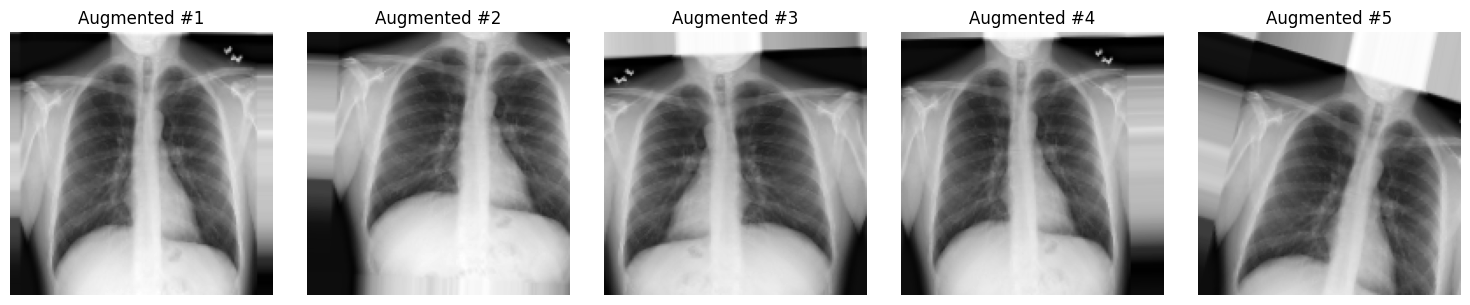

In [20]:
# Pick a sample already from your TB training set (x_train)
x_sample = X_train[0]  # This already has shape (224, 224, 1) and is rescaled

# Function to show augmentations
def plot_augmented_images(datagen, x_sample, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        augmented_img = datagen.random_transform(x_sample)
        plt.subplot(1, n, i + 1)
        plt.imshow(augmented_img.squeeze(), cmap='gray')
        plt.title(f"Augmented #{i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot TB image augmentations
plot_augmented_images(datagen, x_sample)


In [21]:
# Save model
model.save("tb_cnn_model.h5")